In [30]:
import stim
import numpy as np
import pymatching as pm
import matplotlib.pyplot as plt

In [31]:
def gen_dem(distance=3, rounds=5, ps=[1e-3], shots=20000):
    log_errors = []
    data = {}
    for p in ps:
        pname = f"physical_error_rate_{str(p)}"
        data[pname] = []
        circ = stim.Circuit.generated("surface_code:rotated_memory_x",
                                      distance=distance, 
                                      rounds=rounds, 
                                      after_clifford_depolarization=p, # Apply depolarizing noise after Clifford gates (idk what those are atm)
                                      before_round_data_depolarization=p, # Apply depolarizing noise before each round
                                      before_measure_flip_probability=p, # Measurement errors
                                      after_reset_flip_probability=p # Reset errors
                                      )
        
        # get error model, building matching, and get detector and observable samples
        # the error model
        model = circ.detector_error_model(decompose_errors=True)
    
        # pymatching model built on error model
        matching = pm.Matching.from_detector_error_model(model)
    
        # generating syndromes and actual observations
        # syndromes: qubit error detector results * number of rounds for each shot
        # actual_observations: the logical value for each shot
        sampler = circ.compile_detector_sampler()
        syndrome, actual_observations = sampler.sample(shots=shots, separate_observables=True)
        data[pname].append(syndrome)
        data[pname].append(actual_observations)
    
        # predicted (corrected) logical values from running pymatching on syndrome
        predicted_observables = matching.decode_batch(syndrome)
        data[pname].append(predicted_observables)
        
        # count of errors (mismatch between actual and predicted)
        num_errors = np.sum(np.any(predicted_observables != actual_observations, axis=1))
        log_errors.append(num_errors / shots)
    
    return data, np.array(log_errors)

In [39]:
ps = np.linspace(0.001, 0.01, 10)
num_shots = 20000
data, errors = gen_dem(distance=3, rounds=5, ps=ps, shots=num_shots)
print(errors)
# print(f"Syndromes shape (p=0.001): {data['physical_error_rate_.001'][0].shape}")
# print(f"Actual Observations sample shape (p=0.001): {data['physical_error_rate_.001'][1].shape}")
# print(f"Predicted Observations sample shape (p=0.001): {data['physical_error_rate_.001'][2].shape}")

[0.0011  0.00535 0.01275 0.0238  0.02985 0.0415  0.056   0.06795 0.08625
 0.105  ]


In [40]:
# np.savez_compressed('../data/surface_code_data.npz',
#                     detectors=det_samples,
#                     observables=logical_labels)

In [34]:
# np.savetxt('../data/syndrome_samples_p=0.001.csv', data['physical_error_rate_.001'][0], delimiter=',', fmt='%d')
# np.savetxt('../data/actual_observations_samples_p=0.001.csv', data['physical_error_rate_.001'][1], delimiter=',', fmt='%d')
# np.savetxt('../data/predicted_observables_samples_p=0.001.csv', data['physical_error_rate_.001'][2], delimiter=',', fmt='%d')

[0.001 0.002 0.003 0.005 0.008 0.013 0.022 0.036 0.06  0.1  ]


Text(0.5, 1.0, 'Logical error rate at various physical error rates for MWPM baseline algorithm')

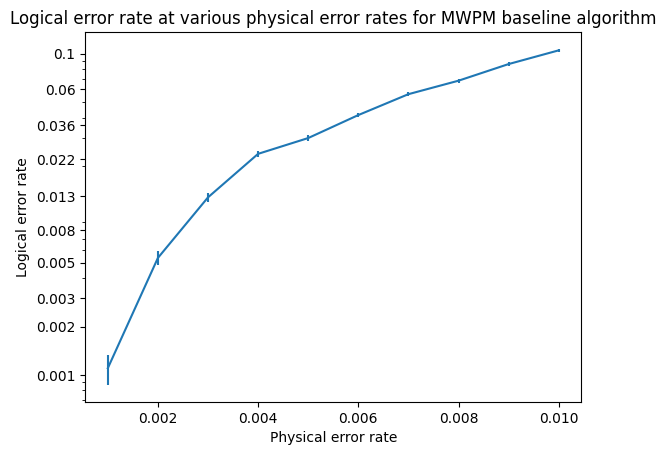

In [51]:
%matplotlib inline

fig, ax = plt.subplots()
# for logical errors in zip(Ls, log_errors_all_L):
std_err = (errors*(1-errors)/num_shots)**0.5
ax.errorbar(ps, errors, yerr=std_err, label="Distance=3")
# for i, j in zip(ps, errors):
#     ax.annotate(str(j), xy=(i, j), xytext=(0, 5), textcoords='offset points', ha='center', va='bottom')
yinterval = np.round(np.logspace(-3, -1, num=10), 3)
print(yinterval)
ax.set_yscale("log")
ax.set_yticks(yinterval)
ax.set_yticklabels(yinterval)
ax.set_xlabel("Physical error rate") 
ax.set_ylabel("Logical error rate") 
ax.set_title("Logical error rate at various physical error rates for MWPM baseline algorithm")
# plt. legend (loc=0);

In [ ]:
fig.savefig()